# look into:
 - look into tdnn
 - convs for discrim
 - lstms for discrim
 - convs for gen
 - lstms for gen

In [50]:
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

In [51]:
class sinDataLoader(Dataset):
    def __init__(self,start,end):
        self.start = start
        self.end = end
        self.pspace = np.arange(start,end+1)
    def return_sin_wave(self, sinmod=1, offset = np.pi*2,step = 1/1000):
        x = np.linspace(0,int(offset),int(1/step))
        y = np.sin(x*(sinmod*step))
        return y
    def __len__(self):
        return len(self.pspace)
    def __getitem__(self,index):
        return self.return_sin_wave(sinmod = self.pspace[index])

In [52]:
dl = DataLoader(sinDataLoader(100,4000),batch_size = 16,shuffle = True)

In [53]:
# plt.plot(next(iter(dl))[8])
# next(iter(dl))[0].shape

In [54]:
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
import torch


In [55]:
in_shape = 1000

In [56]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(in_shape, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512*2, 512*3),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512*3, 512*3),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512*3, 1),
        )

    def forward(self, inp):
        validity = self.model(inp)
        return validity


In [57]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat,0.8))
            layers.append(nn.LeakyReLU(.2, inplace=True))
            return layers

        self.modelL = nn.Sequential(
            *block(1, 128, normalize=False),
            *block(128,128*4),
            *block(128*4, 256*4),
            *block(256*4, 512*4),
            *block(512*4, 1024*4),
            *block(1024*4,1024*8),
            nn.Linear(1024*8,1024*16),
            nn.Linear(1024*16, in_shape),
            nn.Tanh()
        )
        self.modelS = nn.Sequential(
            *block(1, 64, normalize=False),
            *block(64,128),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, in_shape),
            nn.Tanh()
        )
        self.ct1 = nn.ConvTranspose1d(in_channels=1,out_channels=1,kernel_size=3,stride=1,padding=1)
        self.ct2 = nn.ConvTranspose1d(1,8,4,2,1)
        self.cv1 = nn.Conv1d(8,1,4,2,1)
    def forward(self,inp):
            return self.modelL(inp)


In [58]:
k = 2
p = 6
cuda = torch.cuda.is_available()


In [59]:
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()


In [60]:

optimizer_G = torch.optim.Adam(
    generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [61]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
import sys

In [62]:
def innoise(imgs):
    return Variable(torch.abs(Tensor(np.random.normal(
            1.1, 1, (imgs.shape[0], 1)))))

[-+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+-]
 Started Epoch 1
[-+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+-]
 Started Epoch 2
[-+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+-]
 Started Epoch 3
[-+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+-]
 Started Epoch 4
[-+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+-]
 Started Epoch 5
[-+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+-]
 Started Epoch 6
[-+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+-]
 Started Epoch 7
[-+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+-]
 Started Epoch 8
[-+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+-]
 Started Epoch 9
[-+==+--+=

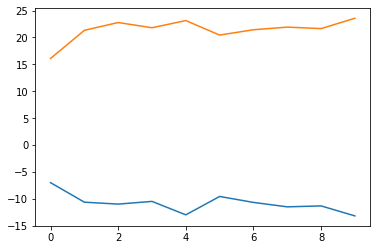

In [71]:
batches_done = 0
n_epochs = 10
savedImgs = []
gloss = []
dloss = []
linsep ="[" +"-+==+-"*15 + "]"
for epoch in range(n_epochs):
    print(f"{linsep}\n Started Epoch {epoch+1}")
    for i, imgs in enumerate(dl):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor), requires_grad=True)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = innoise(imgs)

        # Generate a batch of images
        fake_imgs = generator(z)

        # Real images
        real_validity = discriminator(real_imgs)
        # Fake images
        fake_validity = discriminator(fake_imgs)

        # Compute W-div gradient penalty
        real_grad_out = Variable(
            Tensor(real_imgs.size(0), 1).fill_(1.0), requires_grad=False)
        real_grad = autograd.grad(
            real_validity, real_imgs, real_grad_out, create_graph=True, retain_graph=True, only_inputs=True
        )[0]
        real_grad_norm = real_grad.view(
            real_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

        fake_grad_out = Variable(
            Tensor(fake_imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake_grad = autograd.grad(
            fake_validity, fake_imgs, fake_grad_out, create_graph=True, retain_graph=True, only_inputs=True
        )[0]
        fake_grad_norm = fake_grad.view(
            fake_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

        div_gp = torch.mean(real_grad_norm + fake_grad_norm) * k / 2

        # Adversarial loss
        d_loss = -torch.mean(real_validity) + \
            torch.mean(fake_validity) + div_gp

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # Train the generator every n_critic steps
        # -----------------
        #  Train Generator
        # -----------------

        # Generate a batch of images
        fake_imgs = generator(z)
        # Loss measures generator's ability to fool the discriminator
        # Train on fake images
        fake_validity = discriminator(fake_imgs)
        g_loss = -torch.mean(fake_validity)

        g_loss.backward()
        optimizer_G.step()
        
        
        print(
            f"[Epoch {epoch+1}/{n_epochs}] [Batch {i}/{len(dl)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]",flush=True, end = "\r",
            )
        batches_done += 1
    
    dloss.append(d_loss.item())
    gloss.append(g_loss.item())
    savedImgs.append(generator(torch.full((16,1),1.5,dtype = torch.float, device = "cuda:0"))[2].cpu().detach().numpy())
plt.plot(dloss)
plt.plot(gloss)
plt.show()


In [ ]:
z = Variable(torch.abs(Tensor(np.random.normal(
    1.1, 1, (imgs.shape[0], 1)))))

# Generate a batch of images
fake_imgs = generator(z)
z, z.shape, fake_imgs.shape

(tensor([[0.6976],
         [1.3116],
         [0.7339],
         [1.8104],
         [0.9335],
         [0.5351],
         [0.4345],
         [1.9723],
         [2.0116],
         [0.9660],
         [1.1486],
         [1.4692],
         [1.0520],
         [1.1322],
         [1.3856],
         [0.7761]], device='cuda:0'),
 torch.Size([16, 1]),
 torch.Size([16, 1000]))

Input data: 0.23124249279499054


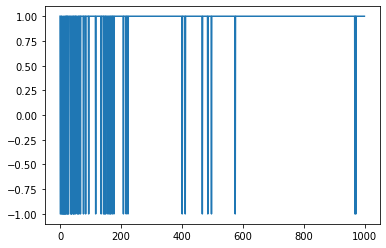

Input data: 1.007612943649292


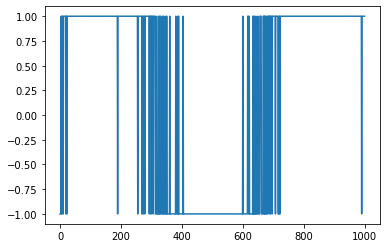

Input data: 0.9649973511695862


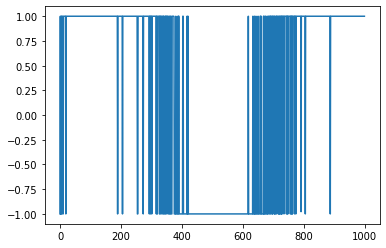

Input data: 1.100966215133667


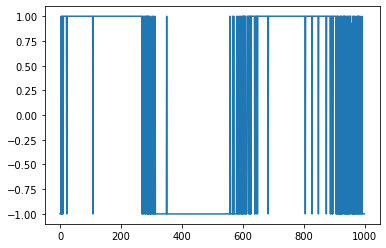

Input data: 1.2835403680801392


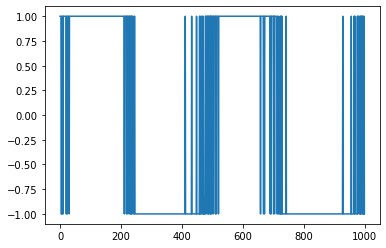

Input data: 0.9422629475593567


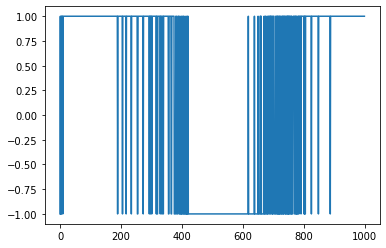

Input data: 0.2861180007457733


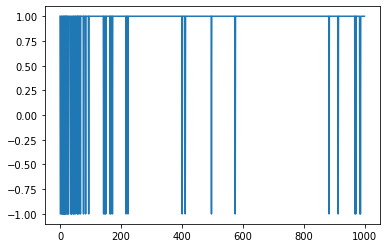

Input data: 1.6749999523162842


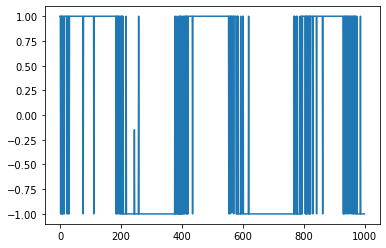

Input data: 1.5619226694107056


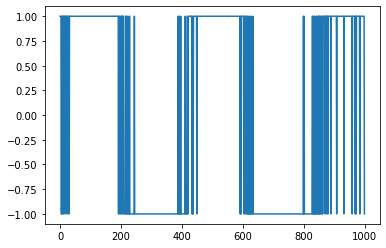

Input data: 1.8689302206039429


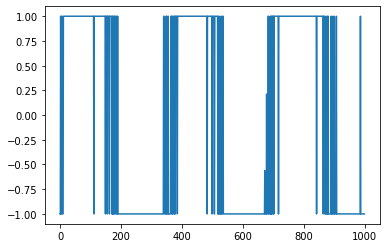

Input data: 3.8953607082366943


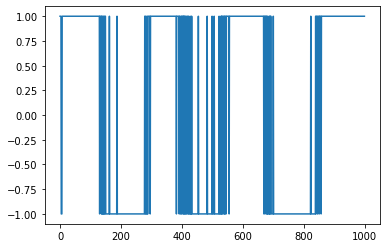

Input data: 0.3325333893299103


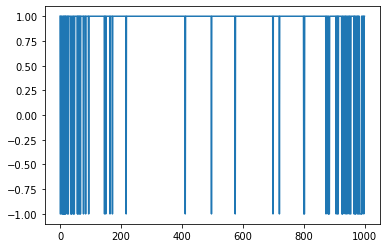

Input data: 2.1975009441375732


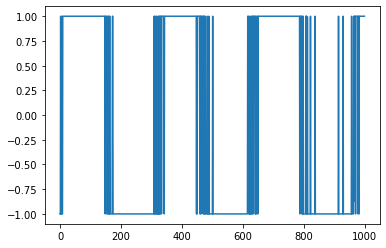

In [72]:
for i,v in zip(fake_imgs,z):
    print(f"Input data: {v[0]}")
    plt.plot(i.cpu().detach().numpy())
    plt.show()